<a href="https://colab.research.google.com/github/cole-beach/Super-Store/blob/main/superstore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superstore Sales Predictions.

This will be based on the [Kaggle Superstore Dataset](https://www.kaggle.com/datasets/vivek468/superstore-dataset-final) where I will be helping a Superstore giant get a better understanding of what works best for them. We will be exploring which products, regions, categories and customer segments to target and which ones to avoid. 

I will be working with a Classification Model and if possible we will also include a Regression model to predict the Sales. 

We have a shape of (9994, 21). I'm not expecting any major challenges with this dataset but as I move through the data modeling process I'll learn more.  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
# Define a function that takes in arguments and prints out a classification report, confusion matrix and ROC AUC
def evaluate_classification(model, X_test, y_test, cmap=None,
                            normalize='true', classes=None, figsize=(20,5)):
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names=classes))

  fig, ax = plt.subplots(ncols=3, figsize=figsize)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Greens',
                                        display_labels=classes,
                                        ax=ax[0])
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                        display_labels=classes, normalize='true',
                                        ax=ax[1])
  
  curve = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[2])
  curve.ax_.grid()
  curve.ax_.plot([0, 1], [0, 1], ls=':')

In [4]:
path = '/content/drive/MyDrive/Coding Dojo: Data Science/Portfolio/Superstore/superstore.csv'
df = pd.read_csv(path)
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [5]:
df.shape

(9994, 21)

In [6]:
df.duplicated().sum()

0

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.duplicated().any()

False

In [9]:
df.drop(columns=['Row ID', 'Order ID', 'Customer ID', 'Country', 'Postal Code'], inplace=True)

In [10]:
# convert our columns with dates data type
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format = '%m/%d/%Y')
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%m/%d/%Y')

In [11]:
# Convert the order date data from datatime64 to int64
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month
df['Order Date'] = df['Order Date'].dt.day

In [12]:
# Convert the shipping data from datatime64 to int64
df['Ship Year'] = df['Ship Date'].dt.year
df['Ship Month'] = df['Ship Date'].dt.month
df['Ship Date'] = df['Ship Date'].dt.day

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order Date     9994 non-null   int64  
 1   Ship Date      9994 non-null   int64  
 2   Ship Mode      9994 non-null   object 
 3   Customer Name  9994 non-null   object 
 4   Segment        9994 non-null   object 
 5   City           9994 non-null   object 
 6   State          9994 non-null   object 
 7   Region         9994 non-null   object 
 8   Product ID     9994 non-null   object 
 9   Category       9994 non-null   object 
 10  Sub-Category   9994 non-null   object 
 11  Product Name   9994 non-null   object 
 12  Sales          9994 non-null   float64
 13  Quantity       9994 non-null   int64  
 14  Discount       9994 non-null   float64
 15  Profit         9994 non-null   float64
 16  Order Year     9994 non-null   int64  
 17  Order Month    9994 non-null   int64  
 18  Ship Yea

In [14]:
df.isna().any()

Order Date       False
Ship Date        False
Ship Mode        False
Customer Name    False
Segment          False
City             False
State            False
Region           False
Product ID       False
Category         False
Sub-Category     False
Product Name     False
Sales            False
Quantity         False
Discount         False
Profit           False
Order Year       False
Order Month      False
Ship Year        False
Ship Month       False
dtype: bool

In [15]:
df.describe()

,Order Date,Ship Date,Sales,Quantity,Discount,Profit,Order Year,Order Month,Ship Year,Ship Month
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,15.468481,15.883730,229.858001,3.789574,0.156203,28.656896,2015.722233,7.809686,2015.737442,7.743146
std,8.748327,8.802677,623.245101,2.225110,0.206452,234.260108,1.123555,3.284654,1.126141,3.340476
min,1.000000,1.000000,0.444000,1.000000,0.000000,-6599.978000,2014.000000,1.000000,2014.000000,1.000000
25%,8.000000,8.000000,17.280000,2.000000,0.000000,1.728750,2015.000000,5.000000,2015.000000,5.000000
50%,15.000000,16.000000,54.490000,3.000000,0.200000,8.666500,2016.000000,9.000000,2016.000000,9.000000
75%,23.000000,24.000000,209.940000,5.000000,0.200000,29.364000,2017.000000,11.000000,2017.000000,11.000000
max,31.000000,31.000000,22638.480000,14.000000,0.800000,8399.976000,2017.000000,12.000000,2018.000000,12.000000


In [16]:
data_types = df.dtypes
str_cols = data_types[data_types =='object'].index
str_cols

for col in str_cols:
   print(f'- {col}:')
   print(df[col].value_counts(dropna=True))
   print("\n\n")

- Ship Mode:
Standard Class    5968
Second Class      1945
First Class       1538
Same Day           543
Name: Ship Mode, dtype: int64



- Customer Name:
William Brown          37
John Lee               34
Matt Abelman           34
Paul Prost             34
Chloris Kastensmidt    32
                       ..
Lela Donovan            1
Anthony O'Donnell       1
Carl Jackson            1
Ricardo Emerson         1
Jocasta Rupert          1
Name: Customer Name, Length: 793, dtype: int64



- Segment:
Consumer       5191
Corporate      3020
Home Office    1783
Name: Segment, dtype: int64



- City:
New York City      915
Los Angeles        747
Philadelphia       537
San Francisco      510
Seattle            428
                  ... 
Glenview             1
Missouri City        1
Rochester Hills      1
Palatine             1
Manhattan            1
Name: City, Length: 531, dtype: int64



- State:
California              2001
New York                1128
Texas                    985
Pennsylva

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order Date     9994 non-null   int64  
 1   Ship Date      9994 non-null   int64  
 2   Ship Mode      9994 non-null   object 
 3   Customer Name  9994 non-null   object 
 4   Segment        9994 non-null   object 
 5   City           9994 non-null   object 
 6   State          9994 non-null   object 
 7   Region         9994 non-null   object 
 8   Product ID     9994 non-null   object 
 9   Category       9994 non-null   object 
 10  Sub-Category   9994 non-null   object 
 11  Product Name   9994 non-null   object 
 12  Sales          9994 non-null   float64
 13  Quantity       9994 non-null   int64  
 14  Discount       9994 non-null   float64
 15  Profit         9994 non-null   float64
 16  Order Year     9994 non-null   int64  
 17  Order Month    9994 non-null   int64  
 18  Ship Yea

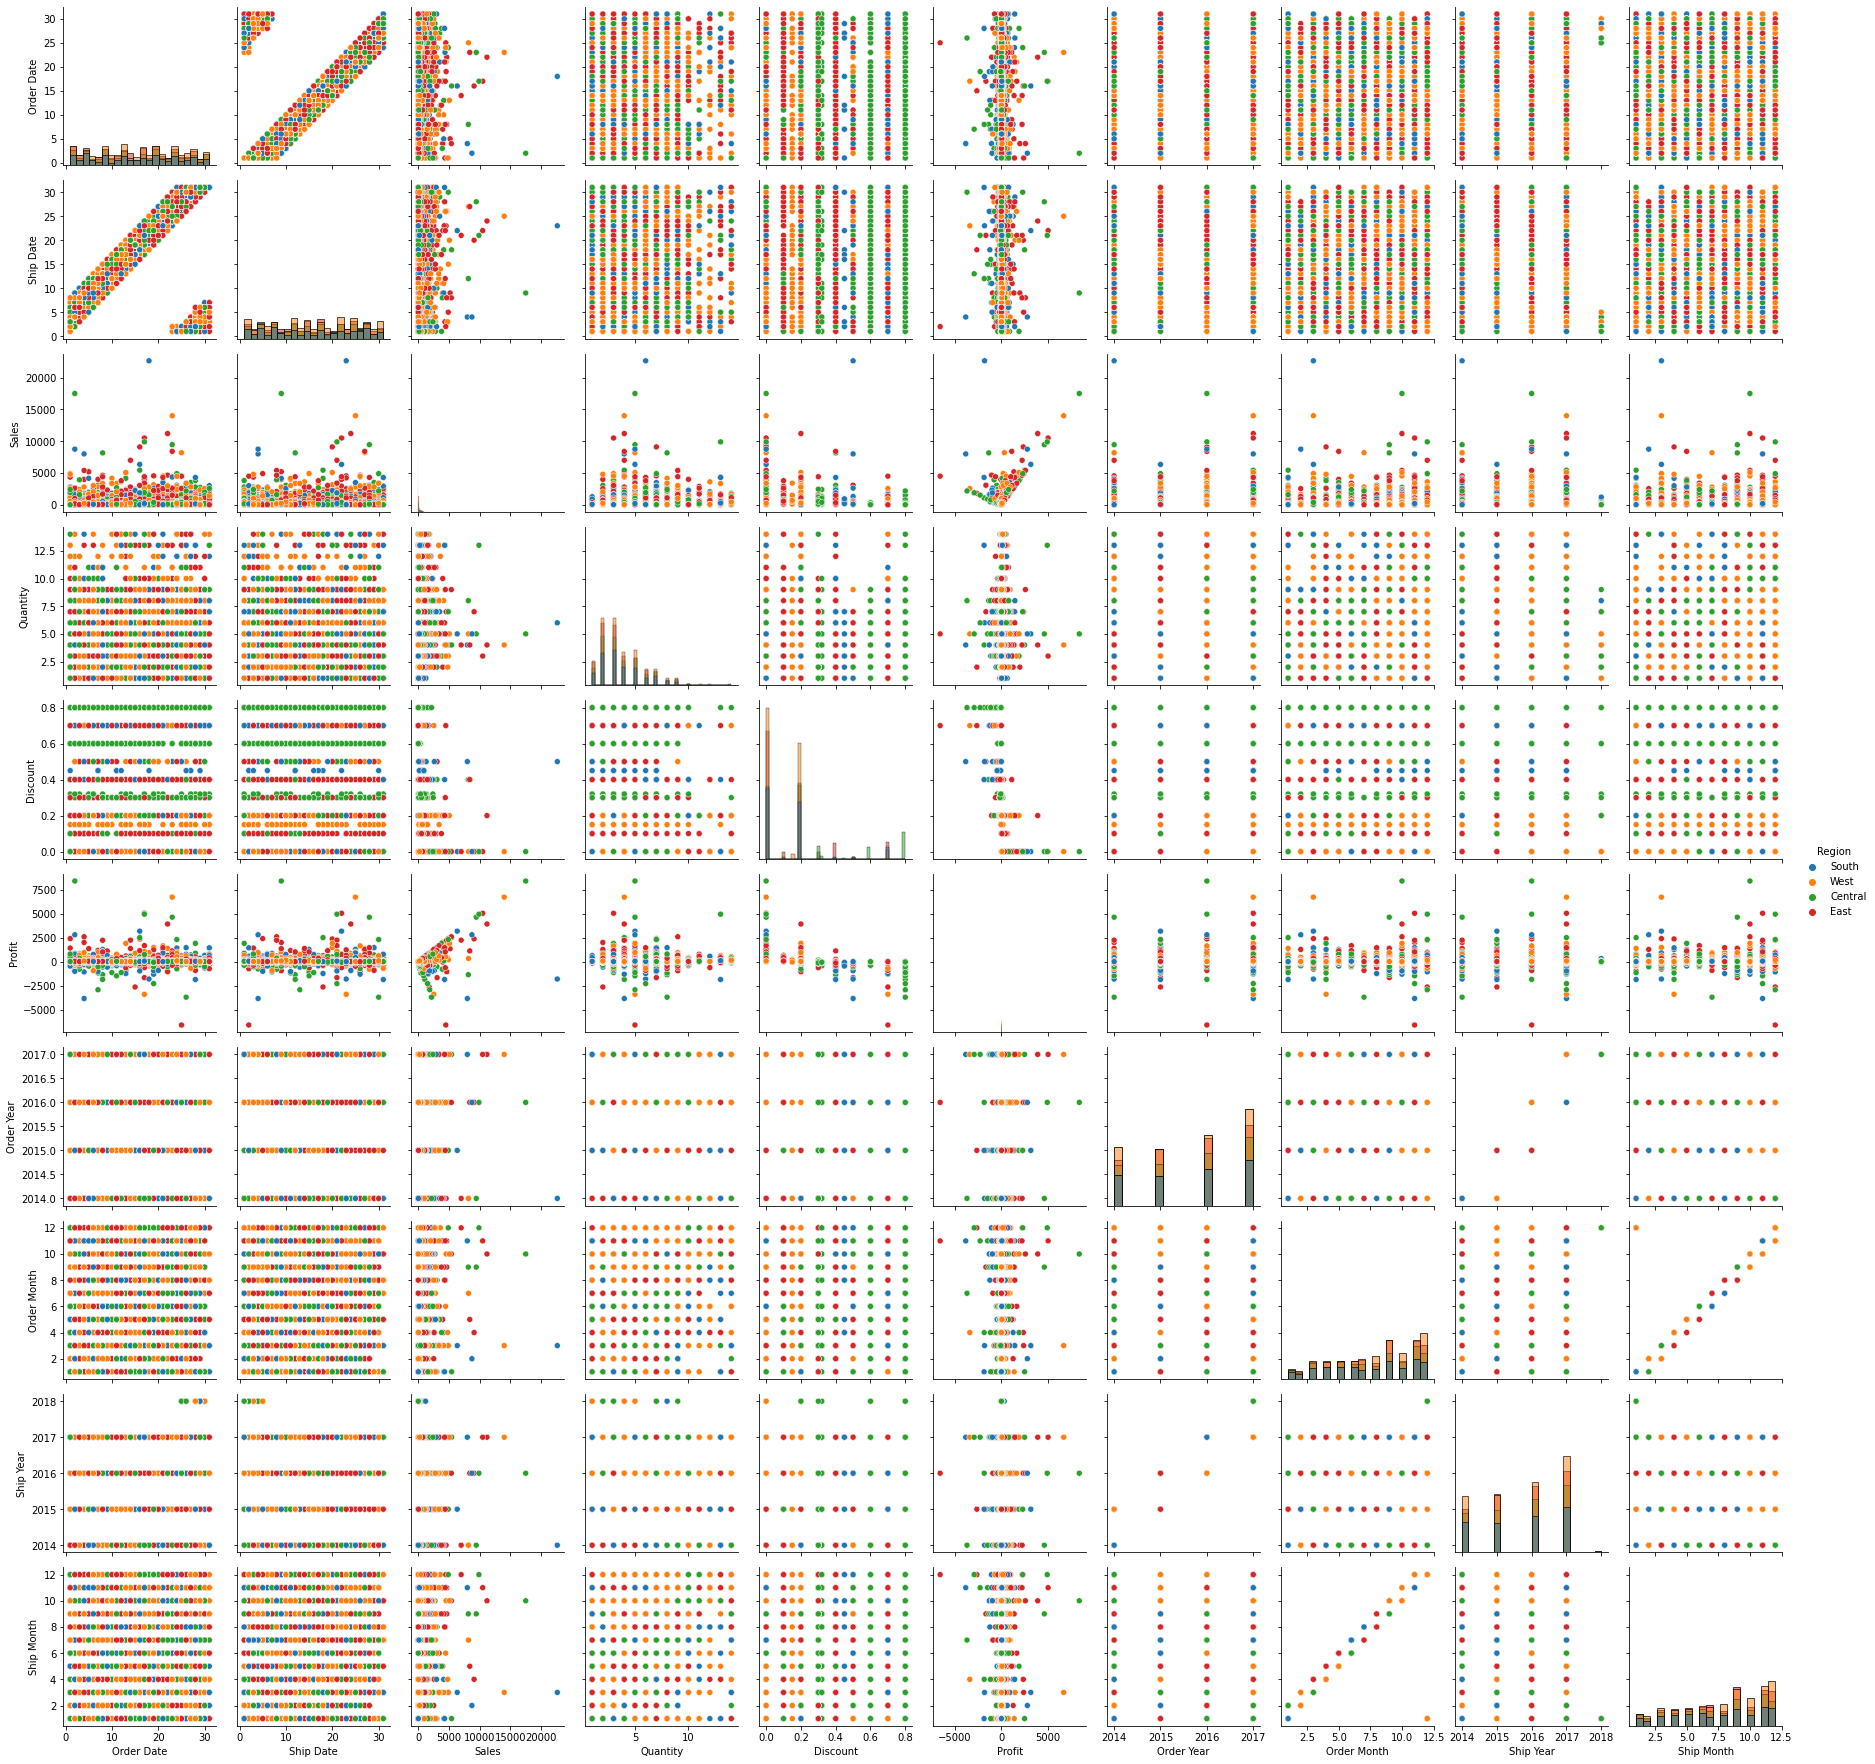

In [18]:
g = sns.PairGrid(df, hue="Region")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend();

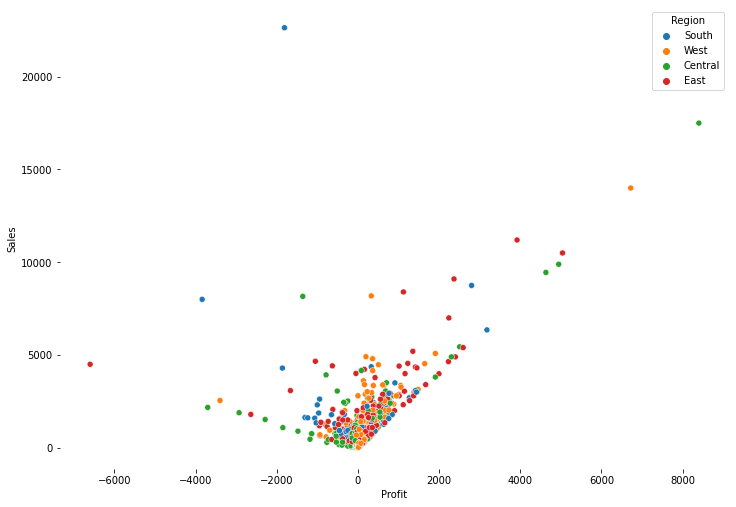

In [19]:
f, ax = plt.subplots(figsize=(12, 8.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(data=df, ax=ax, y='Sales', x='Profit', hue='Region', legend='full');

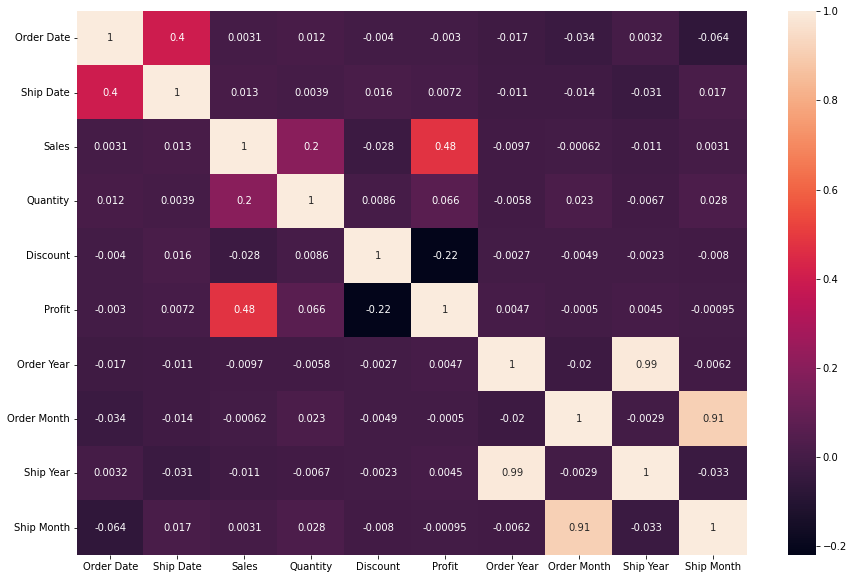

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, ax=ax);

In [21]:
X = df.drop(columns=['Profit'])
y = df['Profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

#column_selectors to tell the column transformers which columns to apply which preprocessing to
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

#imputers, pipelines and tuples
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

num_processor = make_pipeline(mean_imputer, scaler)
cat_processor = make_pipeline(freq_imputer, ohe)

num_tuple = (num_processor, num_selector)
cat_tuple = (cat_processor, cat_selector)

#column transformer
transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')